# Data Visualization

# Brian Hockett, Conor Gibbons, Kalenga Mumba, Ian Kariuki

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.patches as mpatches
from scipy import stats

# Loading data
data = pd.read_csv("../data/cleaned_data.csv")

# Converting date column to datetime
data["Date"] = pd.to_datetime(data["Date"])

# Ignoring the UserWarning raised by the above line. The warning raised tells me that not setting a specific format or handing errors could be problematic, but further
# examination of the Date column showed that it is not, so I am hiding the warning from printing
warnings.simplefilter(action = "ignore", category = UserWarning)
data.head(2)

,Date,About,Period,IMA Jump Count Low Band,IMA Jump Count Med Band,IMA Jump Count High Band,Prop_Jump_Low,Prop_Jump_Med,Prop_Jump_High,Season
0,2022-11-07,Athlete A,Game,16,6,9,0.516129,0.193548,0.290323,1
1,2022-11-07,Athlete C,Game,29,14,6,0.591837,0.285714,0.122449,1


In [2]:
# This code chunk retrieves the n-game (7-game) rolling average of proportion of low, med, and high band jumps

# Empty list to hold rolling_averages data
rolling_averages = []

# Variable for number of games in rolling average
window = 7

# Looping through each group of the df, where the groups are by player
for player, group in data.groupby("About"):
    # Ensuring the dates are in the correct order for the rolling average calculation
    group = group.sort_values(by = "Date")

    # Calculating the rolling averages, over window games, and assigning that to the new column made for that value
    group["Prop_Jump_High"]= group["Prop_Jump_High"].rolling(window, min_periods = 1).mean()
    group["Prop_Jump_Med"]= group["Prop_Jump_Med"].rolling(window, min_periods = 1).mean()
    group["Prop_Jump_Low"]= group["Prop_Jump_Low"].rolling(window, min_periods = 1).mean()

    # Appending the group to the list of groups to be put in a df later
    rolling_averages.append(group)

# Concatenating the rolling average groups. Each player/group is essentially a row in this new dataframe
rolling_df = pd.concat(rolling_averages)

# Filtering out players who have played less than 15 games, as our analysis requires a pretty large sample size

# Getting game count by player
player_games = rolling_df["About"].value_counts()
# Getting the players who have played more than 15 games
players_met_min_games = player_games[player_games >= 15].index
# Limiting rolling_df to only players in the list of players who have played 15 games
rolling_df = rolling_df[rolling_df["About"].isin(players_met_min_games)]
print(len(rolling_df["About"].unique()))

15


In [3]:
# Getting the number of seasons per player, and getting a list of players who are in both seasons
players_seasons = rolling_df.groupby('About')['Season'].nunique()
players_in_both = players_seasons[players_seasons > 1].index.tolist()

# Getting list of all players
players = rolling_df['About'].unique()

# Making a palette where players in 1 season are orange, and players in 2 seasons are navy
palette = {player : ('orange' if player in players_in_both else 'lightgray') for player in players}

## Plot #1

**Description**

Our first plot shows the 7-day rolling average of the proportion of high band jumps for each game. It plots this variable across all players who played more than 15 games. The gray lines show athletes who played in one season, the orange lines show athletes who played in two seasons, and the navy line shows Athlete C, who played two seasons, and had the largest growth in high band jump proportion. Each subplot shows one season plotted in date time. The purpose of this graph is to give the reader a general overview of how players are developing physically (as represented by proportion of high band jump), and how this development differs between players who spent one season vs two seasons in the program. Athlete C is singled out, as his development was the most notable, and he will be explored further in the next plot. By coloring the players by season type (one or two seasons) the viewer is able to see that two season players appear to have more development than one season players.

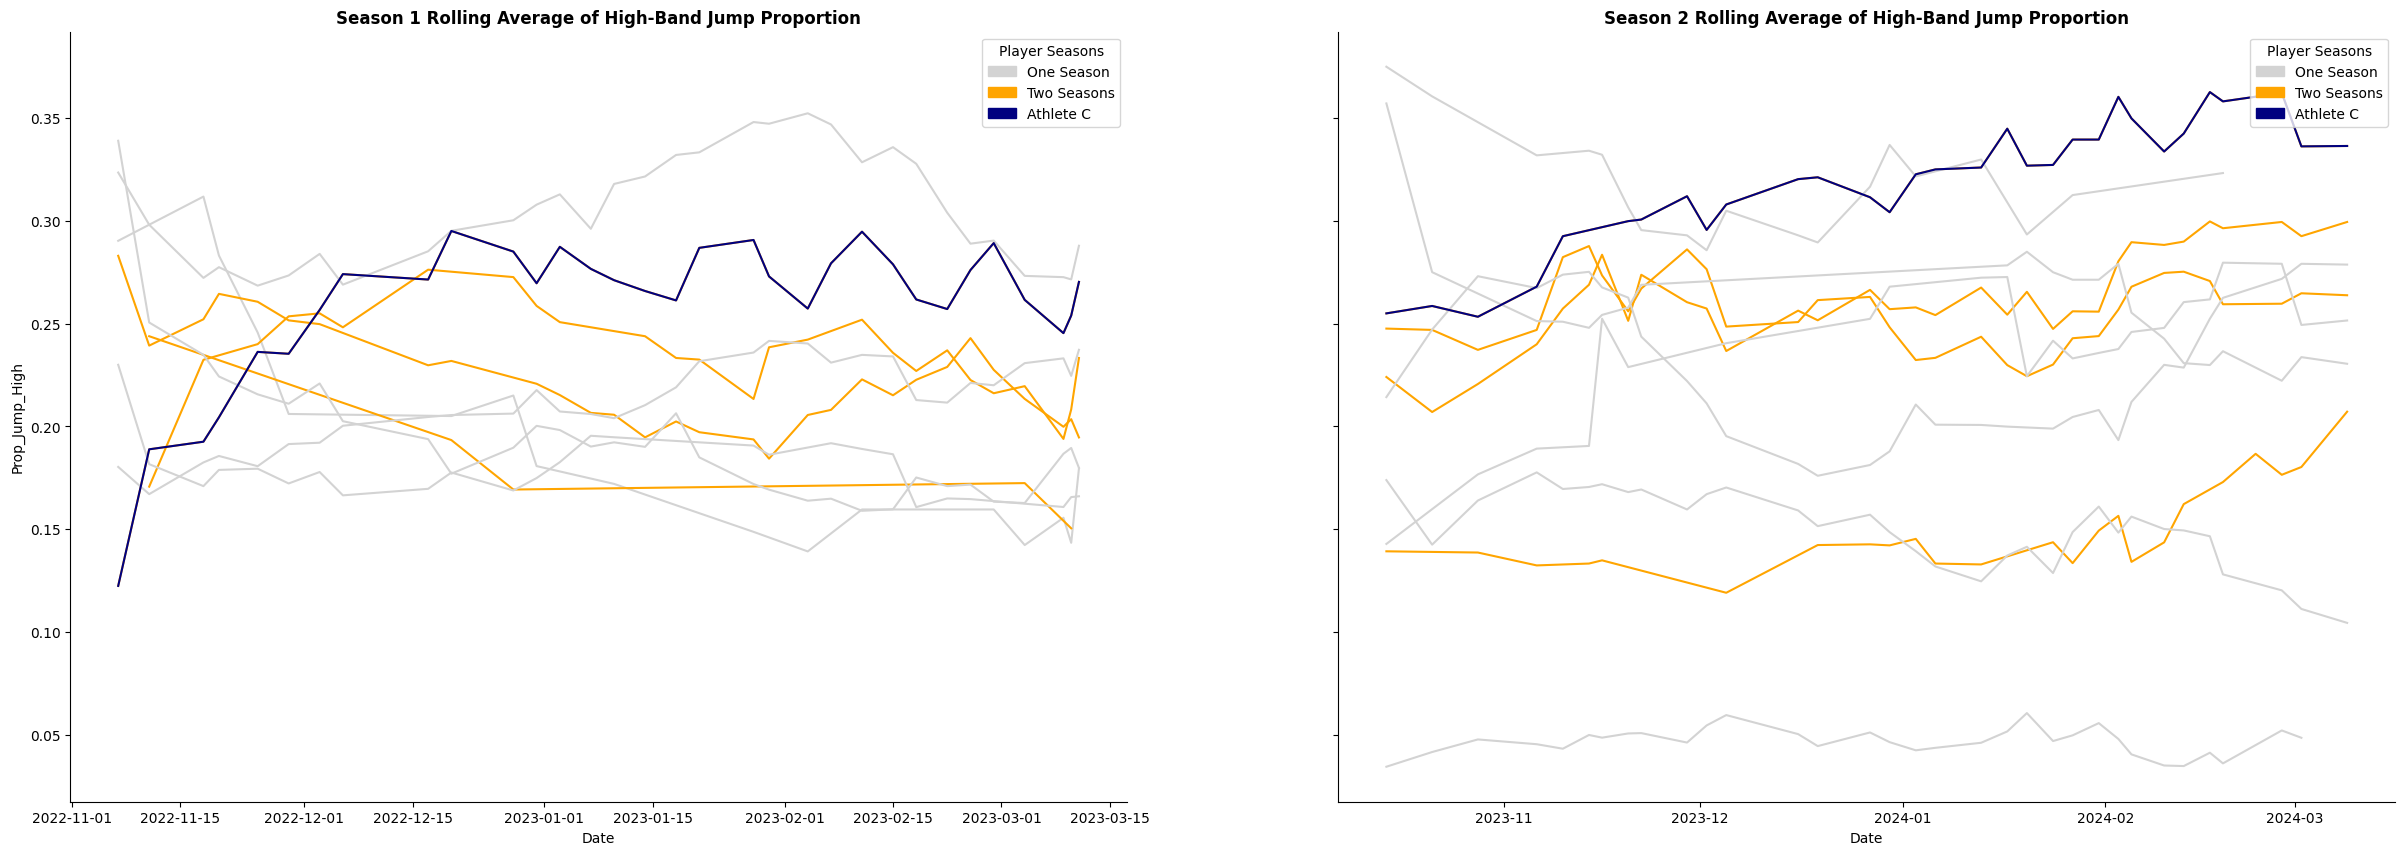

In [4]:
# Creating Figure and Flattening Axes
fig, axs = plt.subplots(1, 2, figsize = (30, 10), sharey = True)
axs = axs.flatten()

# Looping through subplots and seasons
for ax, season in zip(axs, [1, 2]):
    # Making plot of proportion of jumps in high band by player, for each season
    plot = sns.lineplot(data = rolling_df[rolling_df["Season"] == season], x = 'Date', y = "Prop_Jump_High", hue = "About", palette = palette, ax = ax)
    plot_c = sns.lineplot(data = rolling_df[(rolling_df["Season"] == season) & (rolling_df["About"] == "Athlete C")], x = "Date", y = "Prop_Jump_High", color = 'navy', ax = ax)
    ax.set_title(f"Season {season} Rolling Average of High-Band Jump Proportion", weight = 'bold')
    sns.despine(top = True, right = True, ax = ax)

one_season_patch = mpatches.Patch(color = 'lightgray', label = 'One Season')
two_season_patch = mpatches.Patch(color = 'orange', label = 'Two Seasons')
athlete_c_patch = mpatches.Patch(color = "navy", label = "Athlete C")

for ax in axs:
    ax.legend(handles = [one_season_patch, two_season_patch, athlete_c_patch], title = 'Player Seasons', loc = 'upper right')

# Showing plots
plt.show()

## Plot #2

**Description**

The next plot narrows its focus to just one athlete, Athlete C, who has data for both seasons. This plot shows the proportion of low and high band jumps with a 7-day rolling average for just Athlete C. The x-axis plots the real-time combined seasons where the first day of season 2 is one "day" after the final day of season one. The purpose of this is to narrow in on a specific instance of an Athlete who continuously improved jump performance over the course of two seasons. We want to highlight the difference that two seasons can make in a player’s growth, which is exemplified by the growth in Athlete C's high-band proportion, and decrease in low-band proportion, especially in the second season.

In [5]:
# Making a new variable which tells whether or not the player is in both seasons or just one
rolling_df['Player_Group'] = rolling_df['About'].apply(lambda x: 'both_seasons' if x in players_in_both else 'one_season')

# Getting the start date for each season
season_starts = rolling_df.groupby('Season')['Date'].min().to_dict()

# Getting the number of days into the season for each season
rolling_df['Day_of_Season'] = rolling_df.apply(lambda row: (row['Date'] - season_starts[row['Season']]).days + 1, axis=1)

# Getting last day of season 1
season1_length = (rolling_df[rolling_df['Season'] == 1]['Date'].max() - season_starts[1]).days + 1

# Function adds the number of days in the first season to the day in the second season
    # This prevents for example the 5th day in the second season and the 5th day in the first season being seen as the same day
def adjust_day(row):
    if row['Player_Group'] == 'both_seasons' and row['Season'] == 2:
        return row['Day_of_Season'] + season1_length
    else:
        return row['Day_of_Season']

# Adding the first season length to the second seasons
rolling_df['Adjusted_Day'] = rolling_df.apply(adjust_day, axis=1)

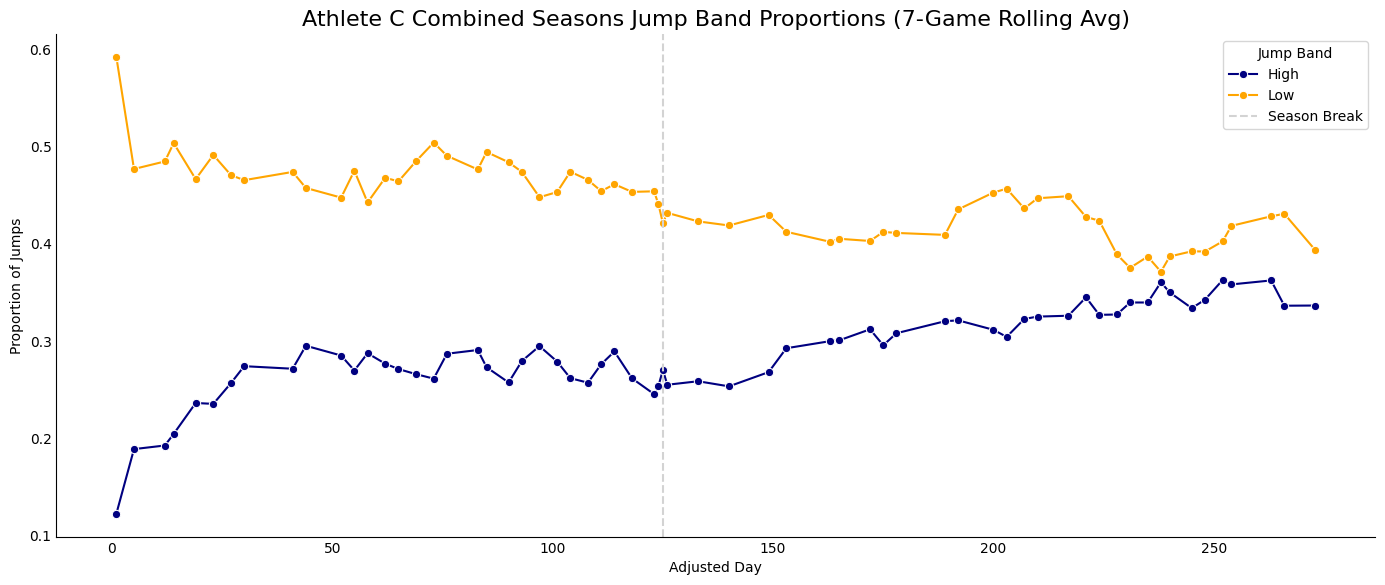

In [63]:
# Filter for Athlete C
Athlete_C = rolling_df[rolling_df["About"] == "Athlete C"]

# Plot both seasons on a single real-time timeline using Adjusted_Day
plt.figure(figsize=(14, 6))

sns.lineplot(data=Athlete_C, x='Adjusted_Day', y='Prop_Jump_High', marker='o', color='navy', label='High')
sns.lineplot(data=Athlete_C, x='Adjusted_Day', y='Prop_Jump_Low', marker='o', color='orange', label='Low')

# Optional: draw line at the transition between Season 1 and Season 2
season1_len = (rolling_df[rolling_df['Season'] == 1]['Date'].max() - rolling_df[rolling_df['Season'] == 1]['Date'].min()).days + 1
plt.axvline(season1_len, linestyle='--', color='lightgray', label='Season Break')

plt.title("Athlete C Combined Seasons Jump Band Proportions (7-Game Rolling Avg)", fontsize=16)
plt.xlabel("Adjusted Day")
plt.ylabel("Proportion of Jumps")
plt.legend(title='Jump Band')
plt.tight_layout()
plt.gca().tick_params(axis = 'both', length = 0)
sns.despine(top = True, right = True)
plt.show()

## Plot #3

**Description**

Our final plot groups the players into two groups; athletes who played for one season and athletes who played for two. We then took the mean proportion of high band jumps for each of these groups on each day of the season. The figure plots these means along with a linear regression trend line for each of the groups. This plot really aims to answer our question of how much playing more than one season influences growth. The trend line clearly shows that one season players have a negatively trending mean proportion of high band jumps whereas the two season groups have a positive one. In all likelihood, the negative trend for one season players is due to fatigue at the end of the season. Nevertheless, the growth of two season players, especially in their second season, shows that player retention and development is still key in college basketball.

   Player_Group     Slope  Intercept   R-value
0  both_seasons  0.000110   0.230065  0.391916
1    one_season -0.000136   0.216189 -0.268255


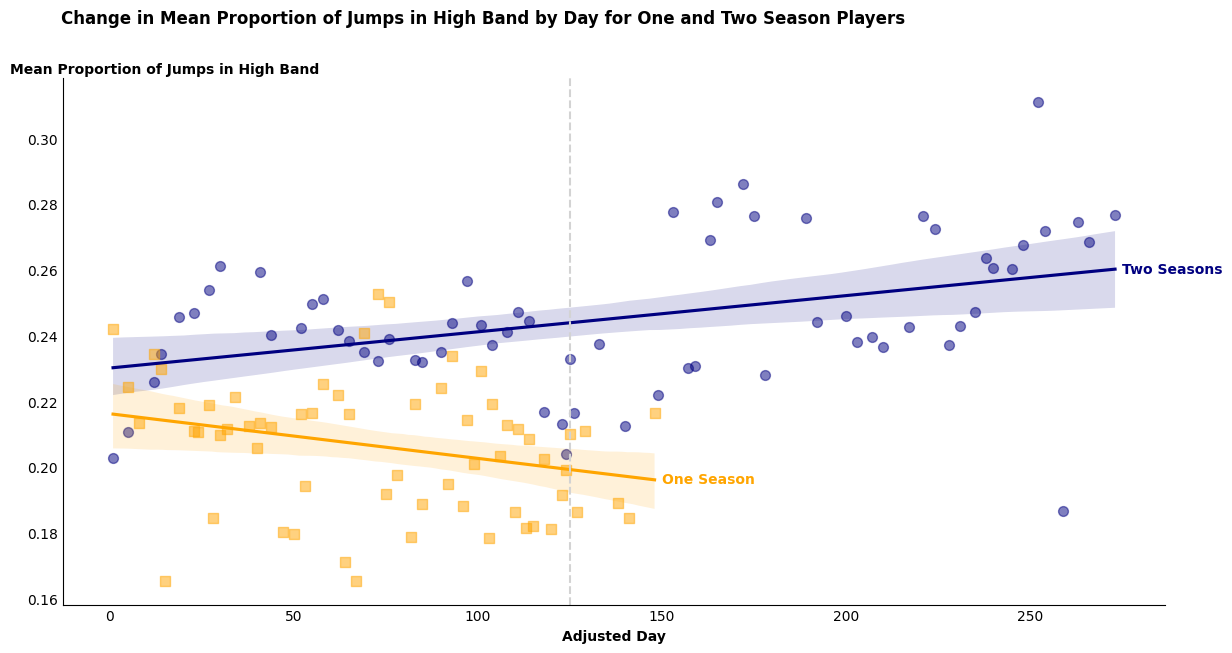

In [68]:
# Grouping by day of the season and whether or not the player was in both seasons, then taking the mean of the prop_jump_high
daily_means = rolling_df.groupby(['Adjusted_Day', 'Player_Group'])['Prop_Jump_High'].mean().reset_index()


# Making a dataframe to hold the required linear regression values
linreg_df = pd.DataFrame(columns=["Player_Group", "Slope", "Intercept", "R-value"])

# Looping through each unique player group
for group in daily_means["Player_Group"].unique():
    # Selecting the relevant data for the current player group
    group_data = daily_means[daily_means["Player_Group"] == group]
    
    # Running linear regression on Adjusted_Day vs Prop_Jump_High
    slope, intercept, r_value, p_value, std_err = stats.linregress(group_data['Adjusted_Day'], group_data['Prop_Jump_High'])
    
    # Adding the linear regression results to the DataFrame
    linreg_df.loc[len(linreg_df)] = [group, slope, intercept, r_value]

# Showing the table with linear regression results
print(linreg_df)

# Making palette for below plot
palette = {
    "both_seasons" : "navy",
    "one_season" : "orange"
}

# Making linear regression plot of prop_jump_high by # seasons played
plot = sns.lmplot(
    data = daily_means,
    x = 'Adjusted_Day',
    y = 'Prop_Jump_High',
    hue = 'Player_Group',
    palette = palette,
    markers = ["o", "s"],
    scatter_kws = {"s": 50, "alpha": 0.5},
    height = 6,
    aspect = 2
)

plt.axvline(x = season1_length, color = 'lightgray', linestyle = '--', label = "Season Break")
plt.suptitle('Change in Mean Proportion of Jumps in High Band by Day for One and Two Season Players'
             , x = 0.375, y = 1.09, weight = "bold")
plt.xlabel('Adjusted Day', weight = 'bold')
plt.text(15, 0.32, "Mean Proportion of Jumps in High Band", ha = 'center', weight = "bold")
#plt.ylabel('Mean Proportion of Jumps in High Band')
plt.ylabel('')
plt.text(275, 0.259, "Two Seasons", color = "navy", weight = 'bold')
plt.text(150, 0.195, "One Season", color = "orange", weight = 'bold')
plt.gca().tick_params(axis = 'both', length = 0)
plot._legend.remove()
plt.show()